### FNO: Solving a diffusion equation for different conductivty
We want to solve the following equation
\begin{align*}
    -\text{div}(\kappa(x) \nabla u(x)) &= 10 &&\text{ in } \Omega, \\
    u &= 0 &&\text{ on } \partial \Omega,
\end{align*}
for functions $\kappa: \Omega \to \mathbb{R}$. As a domain we consider the unit square $\Omega = [0, 1]^2$.

The possible $\kappa$ are created from [perlin noise](https://en.wikipedia.org/wiki/Perlin_noise) and the dataset was created with the finite element method. 

In [ ]:
import torch 
import torchphysics as tp
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

First, we load the data. 
The complete dataset consists of 600 instances of pairs $(\kappa, u)$. 
500 will be used in the training process, while the remaining once are later used to test the FNO on unseen data.

Note that this is quite a small data set and we can not expect to obtain a good generalization of the model. 
This notebook mainly aims to show the code for a 2d example, for good results more data is needed.


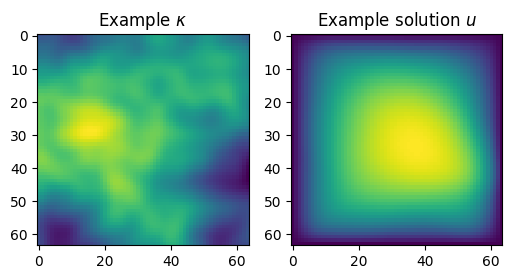

In [10]:
input_data = torch.tensor(np.load("./datasets/diffusion_input_small.npy"), dtype=torch.float32)
output_data = torch.tensor(np.load("./datasets/diffusion_output_small.npy"), dtype=torch.float32)

train_batch_size = 500
train_input = input_data[:train_batch_size]
train_output = output_data[:train_batch_size]

# Plot one example of the data
f, axarr = plt.subplots(1,2, figsize=(6, 10))
plot_idx = 142
axarr[0].imshow(train_input[plot_idx])
axarr[0].title.set_text(r"Example $\kappa$")
axarr[1].imshow(train_output[plot_idx])
axarr[1].title.set_text(r"Example solution $u$")

In TorchPhysics we have to define the input and output space like always:

In [11]:
X = tp.spaces.R2("x")
K = tp.spaces.R1("k")
U = tp.spaces.R1("u")

Next we create the network that learns the mapping:

In [12]:
hidden_channels = 12

model = tp.models.FNO(K, U, 
                      fourier_layers=4, 
                      hidden_channels=hidden_channels, 
                      fourier_modes=(12, 12), # Here two modes need to be set (one for each space direction) 
                      skip_connections=True, 
                      channel_down_sample_network=torch.nn.Sequential(
                          torch.nn.Linear(hidden_channels, hidden_channels),
                          torch.nn.Tanh(),
                          torch.nn.Linear(hidden_channels, U.dim)
                      ))

Now we create a data condition to fit the FNO to the data.

In [ ]:
data_functionset_input = tp.domains.DataFunctionSet(tp.spaces.FunctionSpace(X, K),
                                                    input_data)
data_functionset_output = tp.domains.DataFunctionSet(tp.spaces.FunctionSpace(X, U),
                                                    output_data)

functionsampler_input = tp.samplers.FunctionSamplerOrdered(250, data_functionset_input)
# The output should be coupled to the correct input functions:
functionsampler_output = tp.samplers.FunctionSamplerCoupled(data_functionset_output, functionsampler_input)

data_condition = tp.conditions.OperatorCondition(module=model, 
                                        input_function_sampler=functionsampler_input, 
                                        output_function_sampler=functionsampler_output)

Start training:

In [14]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.005)
solver = tp.solver.Solver([data_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=10000, 
                     logger=False, 
                     enable_checkpointing=False)

trainer.fit(solver)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 7.7 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
7.7 K     Trainable params
0         Non-trainable params
7.7 K     Total params
0.031     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/tp_version2/lib/python3.11/site-packages/pytorch_lightning/tra

Epoch 0: 100%|██████████| 10000/10000 [01:58<00:00, 84.63it/s, train/loss=0.305]

`Trainer.fit` stopped: `max_steps=10000` reached.


Epoch 0: 100%|██████████| 10000/10000 [01:58<00:00, 84.63it/s, train/loss=0.305]


In [18]:
functionsampler_input.n_functions = 500

optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)
solver = tp.solver.Solver([data_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=5000, 
                     logger=False, 
                     enable_checkpointing=False)

trainer.fit(solver)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 7.7 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
7.7 K     Trainable params
0         Non-trainable params
7.7 K     Total params
0.031     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 5000/5000 [00:58<00:00, 85.61it/s, train/loss=0.377]

`Trainer.fit` stopped: `max_steps=5000` reached.


Epoch 0: 100%|██████████| 5000/5000 [00:58<00:00, 85.61it/s, train/loss=0.377]


One could train further and try to optimize the network architecture as well as the training procedure some more. But for this example we are fine with this result. We obtain:

In [19]:
test_input = input_data[train_batch_size:]
test_output = output_data[train_batch_size:]
model_output = model(tp.spaces.Points(test_input, K)).as_tensor

rel_error = torch.max(torch.abs(model_output - test_output)) / torch.max(test_output)

print(f"Relative error: {rel_error*100} %")

Relative error: 45.55434799194336 %


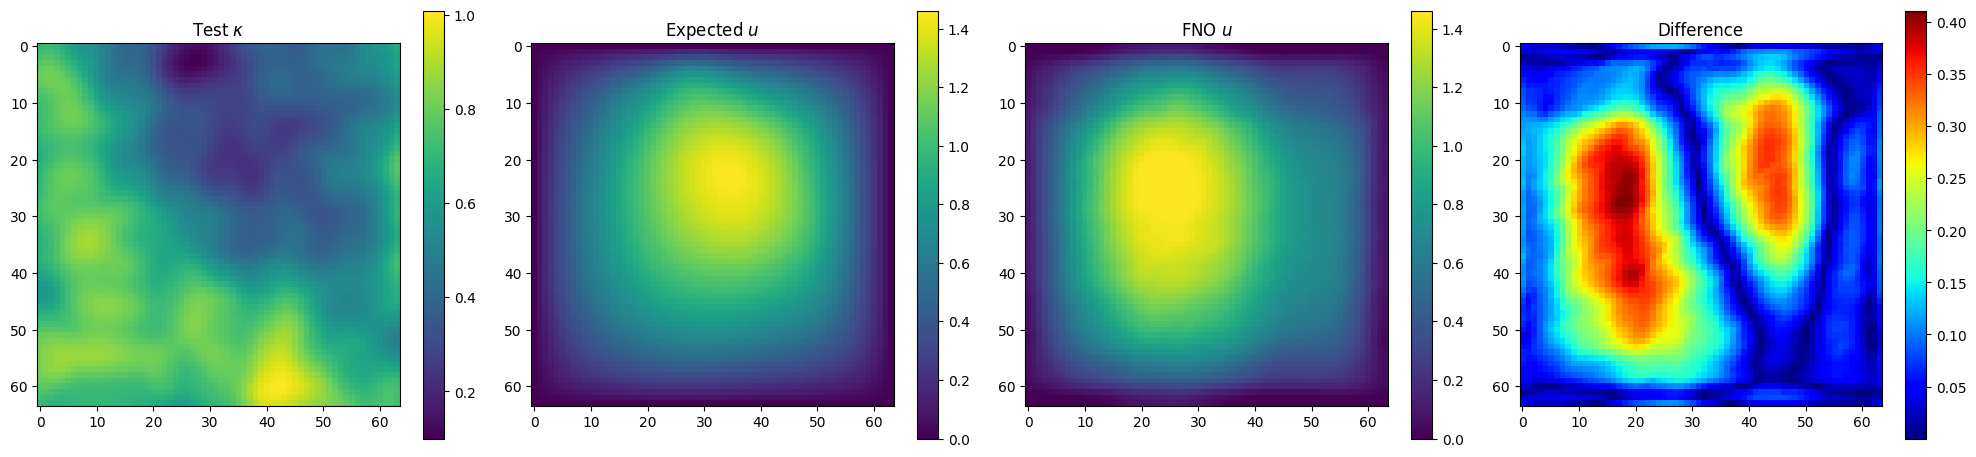

In [20]:
# Plot one example of data
plot_idx = 13 # <- value between 0 and 99

f, axarr = plt.subplots(1,4, figsize=(20, 6))
img = axarr[0].imshow(test_input[plot_idx])
axarr[0].title.set_text(r"Test $\kappa$")
plt.colorbar(img, ax=axarr[0], shrink=0.75)

sol_min = torch.min(test_output[plot_idx])
sol_max = torch.max(test_output[plot_idx])
img = axarr[1].imshow(test_output[plot_idx], vmin=sol_min, vmax=sol_max)
axarr[1].title.set_text(r"Expected $u$")
plt.colorbar(img, ax=axarr[1], shrink=0.75)

img = axarr[2].imshow(model_output[plot_idx].detach(), vmin=sol_min, vmax=sol_max)
axarr[2].title.set_text(r"FNO $u$")
plt.colorbar(img, ax=axarr[2], shrink=0.75)

error = torch.abs(model_output[plot_idx].detach() - test_output[plot_idx])
img = axarr[3].imshow(error, cmap='jet')
axarr[3].title.set_text(r"Difference")
plt.colorbar(img, ax=axarr[3], shrink=0.75)

plt.tight_layout()